# 神经元

### 所有Brian脚本都以以下内容开头

In [1]:
from brian2 import *

INFO       Cache size for target 'cython': 1113037011 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\kyle\.cython\brian_extensions' directory. [brian2]


In [2]:
# 激活内联绘图
%matplotlib inline

## 单位制

In [3]:
# 伏特
20*volt

20. * volt

In [4]:
# 安培
1000*amp

1. * kamp

In [5]:
1e6*volt

1. * Mvolt

In [6]:
1000*namp

1. * uamp

In [7]:
10*nA

10. * namp

In [8]:
10*nA*Mohm

10. * mvolt

## 一个简单的模型
- ### 在brian中，所有的神经元模型都有微分方程定义

In [9]:
tau = 10*ms
# 方程只是一个字符串，每个方程有一行
eqs = '''
dv/dt = (1-v) / tau : 1   
'''
# tau：方程定义变量的 SI 单位

In [10]:
# 使用上面的定义和类NeuronGroup（）来创建一个神经元
G = NeuronGroup(1, eqs)    #前两个参数是：1.神经元的数量；2.定义的微分方程

In [11]:
#run(100*ms)   # 运行模拟100毫秒

In [12]:
# 通过v在模拟前后打印出的变量数值来观察
print('before v = %s' % G.v[0])
run(100*ms)   # 运行模拟100毫秒
print('after v = %s' % G.v[0])

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.14s). [brian2.stateupdaters.base.method_choice]


before v = 0.0
after v = 0.9999546000702376


In [13]:
'''
默认情况下，所有变量都从值 0 开始。由于微分方程是dv/dt=(1-v)/tau我们预期
一段时间后v 会趋向于值 1，这正是我们所看到的。具体来说，我们希望v有 value
1-exp(-t/tau)'''
print('Expected value of v = %s' %(1-exp(-100*ms/tau)))

Expected value of v = 0.9999546000702375


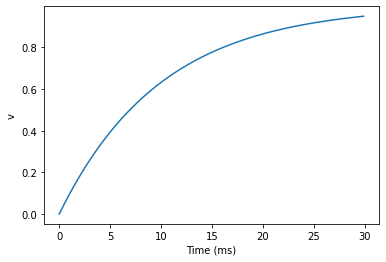

In [14]:
#确保在调用该函数之前创建的任何 Brian 对象都不会包含在下一次模拟运行中
start_scope()

G = NeuronGroup(1, eqs, method='exact')
#将模拟得到的数据记录下来，前两个参数是要记录的组和要记录的变量
'''
指定了record=0. 这意味着我们记录神经元 0 的所有值。我们必须指定
我们想要记录哪些神经元，因为在具有许多神经元的大型模拟中，它通常会
占用太多 RAM 来记录所有神经元的值
'''
M = StateMonitor(G, 'v', record=True)   

run(30*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

Text(0, 0.5, 'v')

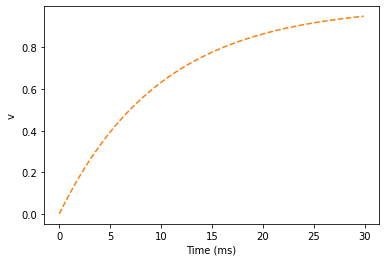

In [15]:
#通过在顶部绘制预期行为来分析检查
plot(M.t/ms, 1-exp(-M.t/tau), 'C1--',label='Analytic')
xlabel('Time (ms)')
ylabel('v')

## 添加尖峰

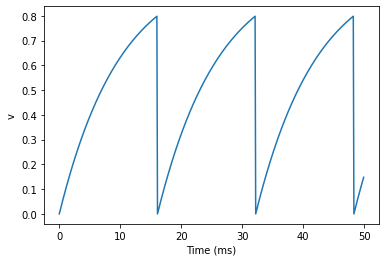

In [16]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''
# 阈值为0.8v，直到v超过阈值v>0.8，此时它重置为 0
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=0)
run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

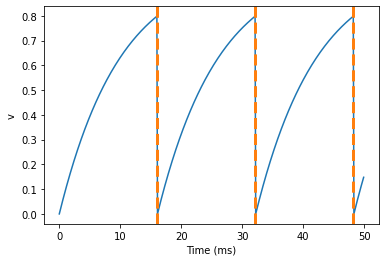

In [20]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0.0', method='exact')

statemon = StateMonitor(G, 'v', record=0)

#SpikeMonitor对象将要记录其峰值的组作为其参数，
#并将峰值时间存储在变量中t
spikemon = SpikeMonitor(G)

run(50*ms)

#绘制这些尖峰
plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
    
xlabel('Time (ms)')
ylabel('v');

## 不应性
- ### 神经元模型的一个共同特征是不应期。这意味着在神经元发射一个尖峰后，它会在一段时间内变得顽固，并且在这段时间结束之前不能再发射另一个尖峰

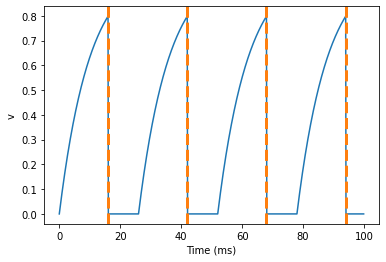

In [22]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''
#(unless refractory):意味着微分方程决定了除非它是不应性的， 否则它会被关闭

#refractory=5*ms：意味着神经元不能在此期间尖峰，但不会改变v行为方式
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=10*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(100*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

Spike times: [ 8. 23. 38.] ms


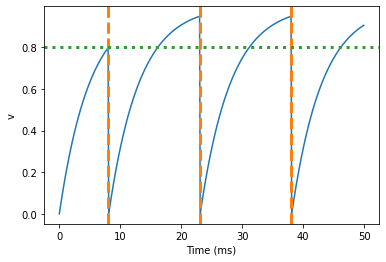

In [24]:
# 如果在微分方程中不包括(unless refractory)
start_scope()

tau = 5*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=15*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
axhline(0.8, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('v')
print("Spike times: %s" % spikemon.t[:])

# 多个神经元

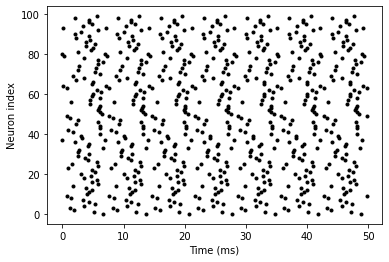

In [25]:
start_scope()

N = 100   #神经元的数量
tau = 10*ms
eqs = '''
dv/dt = (2-v)/tau : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')

#在运行前，用 0 到 1 之间不同的统一随机值初始化每个神经元
G.v = 'rand()'   

spikemon = SpikeMonitor(G)

run(50*ms)

'''
使用了spikemon.i为每个尖峰提供相应神经元索引的变量;
绘制了一个带有时间的黑点，黑点表示某个神经元在某一时间有一个脉冲
'''
plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

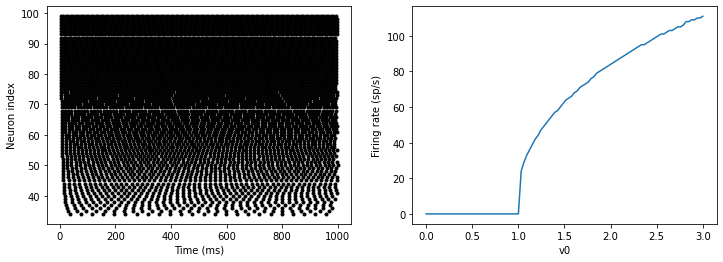

In [26]:
# 随着微分方程的神经元参数变化，

start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''
#每个神经元声明了一个新的神经元参数 v0，单位为 1（即无量纲）

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'   #初始化每个神经元的 v0 值，从 0 到 v0_max

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)

#使用了 SpikeMonitor 的计数变量， 将其除以运行的持续时间得出点火率
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

#### 它发射尖峰的速率将与 v0 的值相关。 对于 v0<1，它永远不会触发尖峰，随着 v0 变大，它将以更高的速率触发尖峰

## 随机神经元
- #### 在制作神经元模型时，我们会包含一个随机元素来模拟各种形式的神经噪声的影响

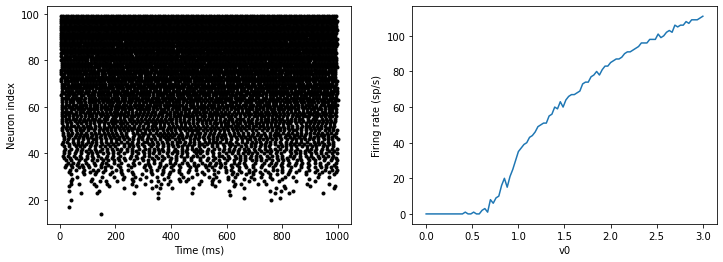

In [28]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms
sigma = 0.2

#sigma*xi：可以把它看作只是一个均值为 0 和标准差为 1 的高斯随机变量
#tau**-0.5：考虑随机微分随时间缩放的方式
eqs = '''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

#更改了method要使用的 关键字参数'euler'（代表 Euler-Maruyama 方法）；
#这'exact' 我们之前使用的方法不适用于随机微分方程
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', 
                refractory=5*ms, method='euler')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');